# LSTM을 이용한 교통 흐름 예측

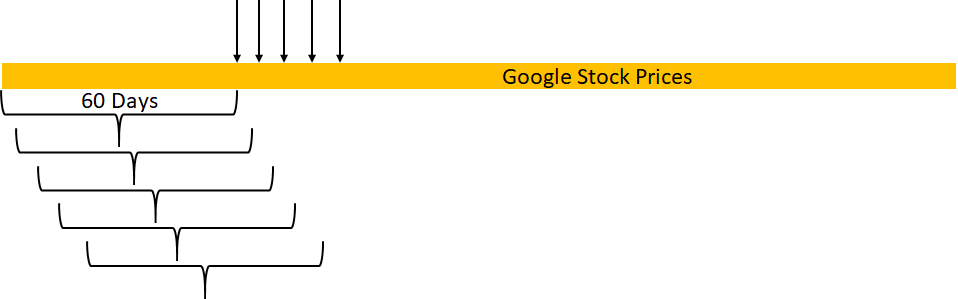

# VDS 데이터를 이용한 교통 흐름 예측 모델 단계 

- Data Preprocessing
- Building the RNN
- Making the prediction and visualization

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler

In [2]:
from pandas import datetime
def parser(x):
    return datetime.strptime(x, '%Y-%m-%d %H:%M')

C:\Python37\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: The pandas.datetime class is deprecated and will be removed from pandas in a future version. Import from datetime module instead.
  """Entry point for launching an IPython kernel.


In [3]:
df = pd.read_csv('./daejeon_vds16.csv',  date_parser=parser)

In [4]:
df.head()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
0,2017-04-02 0:00,43,34,9,0,50.3,1.90
1,2017-04-02 0:05,45,32,13,0,58.9,1.84
2,2017-04-02 0:10,46,34,12,0,50.6,1.87
3,2017-04-02 0:15,45,36,9,0,50.9,1.72
4,2017-04-02 0:20,27,13,13,1,62.2,1.12


In [5]:
df.shape

(8064, 7)

In [6]:
df.tail()

,Date,ToVol,SmVol,MeVol,LaVol,Speed,Occ.Rate
8059,2017-04-29 23:35,45,35,10,0,51.3,2.01
8060,2017-04-29 23:40,47,33,14,0,53.9,1.89
8061,2017-04-29 23:45,32,28,4,0,50.6,1.36
8062,2017-04-29 23:50,31,21,10,0,59.3,1.40
8063,2017-04-29 23:55,39,33,6,0,52.5,1.74


## 정규화를 위하여 'Data' 특성을 제외하자

In [7]:
data_training  = df[df['Date'] <'2017-04-28'].copy() 
data_test = df[df['Date'] >='2017-04-28'].copy()

### Speed(속도) 데이터만을 선택해보자

In [8]:
data_training = data_training.drop(['Date','ToVol','SmVol','MeVol','LaVol','Occ.Rate'], axis = 1)
data_test = data_test.drop(['Date','ToVol','SmVol','MeVol','LaVol','Occ.Rate'], axis = 1)

In [9]:
data_training.head()

,Speed
0,50.3
1,58.9
2,50.6
3,50.9
4,62.2


## 정규화 

In [10]:
scaler = MinMaxScaler()
data_training = scaler.fit_transform(data_training)
data_test = scaler.fit_transform(data_test)

In [11]:
data_training.shape

(7488, 1)

In [12]:
data_test.shape

(576, 1)

# RNN을 위하여 데이터를 재구성하자.
### Loop_Back = 60으로 설정하자.
### 예측은 단일 예측 1개로 즉, 5분단위
create RNN with 60 timesteps, i.e. look 60 previous time steps

In [13]:
X_train = []
y_train = []
X_test = []
y_test = []

In [14]:
data_training.shape[0]

7488

In [15]:
data_test.shape[0]

576

### train 데이터를 RNN 구조로 만들자

In [16]:
for i in range(60, data_training.shape[0]):
    X_train.append(data_training[i-60:i])
    y_train.append(data_training[i, 0])

In [17]:
X_train, y_train = np.array(X_train), np.array(y_train)

In [18]:
X_train.shape

(7428, 60, 1)

### test 데이터에도 같은 구조로 해주자

In [19]:
for i in range(60, data_test.shape[0]):
    X_test.append(data_test[i-60:i])
    y_test.append(data_test[i, 0])

In [20]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [21]:
X_test.shape, y_test.shape

((516, 60, 1), (516,))

### Building LSTM 

In [22]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [23]:
model = Sequential()
model.add(LSTM(units = 60, activation = 'relu', return_sequences = True,
               input_shape = (X_train.shape[1], 1)))
model.add(LSTM(units = 60, activation = 'sigmoid'))

model.add(Dense(units = 1))

In [24]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 60)            14880     
                                                                 
 lstm_1 (LSTM)               (None, 60)                29040     
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
Total params: 43,981
Trainable params: 43,981
Non-trainable params: 0
_________________________________________________________________


In [25]:
model.compile(optimizer='adam', loss = 'mean_squared_error',
             metrics =['accuracy'])

In [26]:
history= model.fit(X_train, y_train, epochs=5, batch_size=256)

Epoch 1/3
30/30 [==============================] - 26s 775ms/step - loss: 0.0914 - accuracy: 1.3463e-04
Epoch 2/3
30/30 [==============================] - 23s 754ms/step - loss: 0.0124 - accuracy: 1.3463e-04
Epoch 3/3
30/30 [==============================] - 23s 757ms/step - loss: 0.0092 - accuracy: 2.6925e-04


In [27]:
print(history.history)

{'loss': [0.09142845124006271, 0.01238595973700285, 0.009211527183651924], 'accuracy': [0.00013462573406286538, 0.00013462573406286538, 0.00026925146812573075]}


In [28]:
history.history.keys()

dict_keys(['loss', 'accuracy'])

### Prepare test dataset 

In [29]:
X_test, y_test = np.array(X_test), np.array(y_test)

In [30]:
X_test.shape, y_test.shape

((516, 60, 1), (516,))

In [41]:
model.evaluate(X_test, y_test, batch_size=128)

5/5 [==============================] - 0s 70ms/step - loss: 1387.8113 - accuracy: 0.0019


[1387.811279296875, 0.0019379844889044762]

In [31]:
y_pred = model.predict(X_test)

In [32]:
y_pred

array([[0.5196103 ],
       [0.51958615],
       [0.51965153],
       [0.5210893 ],
       [0.52114886],
       [0.52041614],
       [0.521863  ],
       [0.5225507 ],
       [0.52398515],
       [0.52527   ],
       [0.5271542 ],
       [0.52746594],
       [0.5268582 ],
       [0.5265019 ],
       [0.5261961 ],
       [0.5254935 ],
       [0.52421784],
       [0.5244183 ],
       [0.52369386],
       [0.5244552 ],
       [0.5236645 ],
       [0.5229633 ],
       [0.52328604],
       [0.5230562 ],
       [0.5222318 ],
       [0.5213609 ],
       [0.52063173],
       [0.51972955],
       [0.5178206 ],
       [0.5158281 ],
       [0.5132814 ],
       [0.51089394],
       [0.5081454 ],
       [0.5060609 ],
       [0.5048417 ],
       [0.50446594],
       [0.5041324 ],
       [0.5030101 ],
       [0.5023257 ],
       [0.50136155],
       [0.50168383],
       [0.5002449 ],
       [0.499008  ],
       [0.49797472],
       [0.49783227],
       [0.49880937],
       [0.49964124],
       [0.500

In [33]:
scaler.scale_

array([0.01547988])

In [34]:
#scale = 1/8.18605127e-04
scale = 1/0.01547988

In [35]:
y_pred = y_pred*scale
y_test = y_test*scale

In [36]:
y_pred

array([[33.566814],
       [33.565258],
       [33.56948 ],
       [33.66236 ],
       [33.666206],
       [33.618874],
       [33.71234 ],
       [33.756767],
       [33.84943 ],
       [33.932434],
       [34.054153],
       [34.07429 ],
       [34.03503 ],
       [34.012012],
       [33.99226 ],
       [33.946873],
       [33.864464],
       [33.877415],
       [33.830616],
       [33.879795],
       [33.828716],
       [33.78342 ],
       [33.804268],
       [33.78942 ],
       [33.736168],
       [33.679905],
       [33.6328  ],
       [33.57452 ],
       [33.451202],
       [33.322483],
       [33.15797 ],
       [33.00374 ],
       [32.826183],
       [32.691525],
       [32.612766],
       [32.58849 ],
       [32.566944],
       [32.494442],
       [32.450233],
       [32.387947],
       [32.408768],
       [32.315815],
       [32.23591 ],
       [32.16916 ],
       [32.159958],
       [32.223076],
       [32.276817],
       [32.361202],
       [32.46675 ],
       [32.569374],


### Visualization 

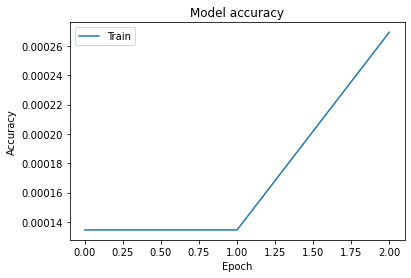

In [37]:
# 6 훈련 과정 시각화 (정확도)
plt.plot(history.history['accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

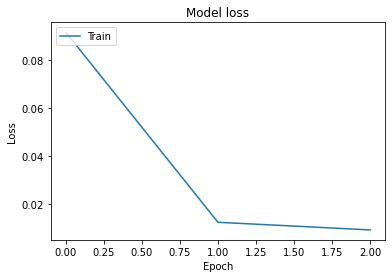

In [38]:
# 7 훈련 과정 시각화 (손실)
plt.plot(history.history['loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

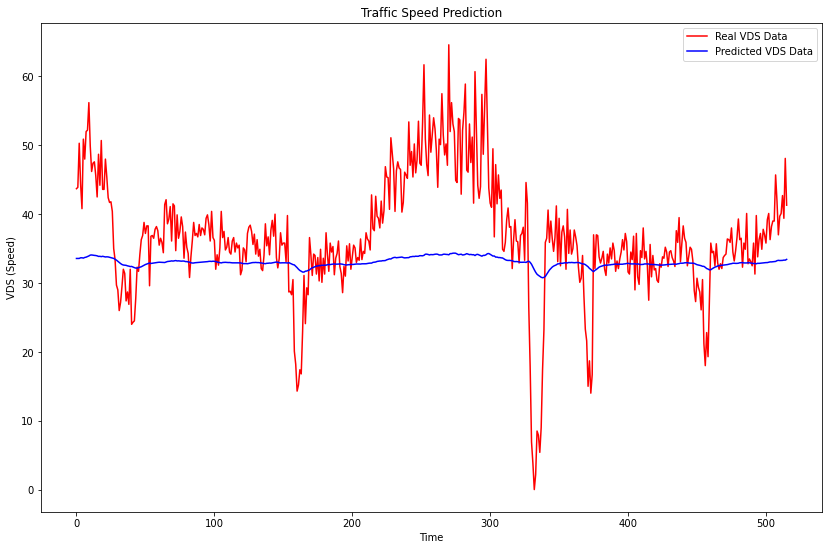

In [43]:
# Visualising the results
plt.figure(figsize=(14,9))
plt.plot(y_test, color = 'red', label = 'Real VDS Data')
plt.plot(y_pred, color = 'blue', label = 'Predicted VDS Data')
plt.title('Traffic Speed Prediction')
plt.xlabel('Time')
plt.ylabel('VDS (Speed)')
plt.legend()
plt.show()